# Protein function Prediction

This notebook trains a DNN model using TensorFlow on the CAFA 5 protein function dataset.

The objective of the model is to predict the function (i.e., **GO term ID**) of a set of proteins based on their amino acid sequences and other data.


**Note** : This notebook runs without any GPU however we have trained our model on T4 GPU. This is because enabling GPUs leaves less RAM memory on the instance and the output prediction step needs a substantial amount of memory. While training with CPU it will take around 2 minutes while on GPU it would take around 30 seconds.

## About the Data

### Protein Sequence

Each protein is composed of dozens or hundreds of amino acids that are linked sequentially. Each amino acid in the sequence may be represented by a one-letter or three-letter code. Thus the sequence of a protein is often notated as a string of letters.

The `train_sequences.fasta` contains the sequences for proteins with annotations (labelled proteins).

# Gene Ontology

We can define the functional properties of a proteins using Gene Ontology (GO). Gene Ontology (GO) describes our understanding of the biological domain with respect to three aspects:
1. Molecular Function (MF)
2. Biological Process (BP)
3. Cellular Component (CC)

Read more about Gene Ontology [here](http://geneontology.org/docs/ontology-documentation).

File `train_terms.tsv` contains the list of annotated terms (ground truth) for the proteins in `train_sequences.fasta`. In `train_terms.tsv` the first column indicates the protein's UniProt accession ID (unique protein id), the second is the `GO Term ID`, and the third indicates in which ontology the term appears.

# Labels of the dataset

The objective of our model is to predict the terms (functions) of a protein sequence. One protein sequence can have many functions and can thus be classified into any number of terms. Each term is uniquely identified by a `GO Term ID`. Thus our model has to predict all the `GO Term ID`s for a protein sequence.

# Protein embeddings for train and test data

To train our model we cannot use the alphabetical protein sequences in`train_sequences.fasta` directly. They have to be converted into a vector format. We will use embeddings of the protein sequences to train the model. You can think of protein embeddings to be similar to word embeddings used to train NLP models.

Protein embeddings are a machine-friendly method of capturing the protein's structural and functional characteristics, mainly through its sequence. One approach is to train a custom ML model to learn the protein embeddings of the protein sequences in the dataset being used in this notebook. Since this dataset represents proteins using amino-acid sequences which is a standard approach, we can use any publicly available pre-trained protein embedding models to generate the embeddings.

To make data preparation easier, we have used the precalculated protein embeddings created by [Sergei Fironov](https://www.kaggle.com/sergeifironov) using the Rost Lab's T5 protein language model in this notebook. The precalculated protein embeddings can be found [here](https://www.kaggle.com/datasets/sergeifironov/t5embeds).

# Import the Required Libraries

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import progressbar

2023-09-17 01:35:13.825393: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/openmpi-4.1.2-4a/lib:/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib:/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/tcl-8.6.11-d4/lib:/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/sqlite-3.37.1-6s/lib:/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/zlib-1.2.11-2y/lib:/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-9.3.0/gcc-10.3.0-ya/lib64:/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-9.3.0/gcc-10.3.0-ya/lib
2023-09-17 01:35:13.825433: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
print("TensorFlow v" + tf.__version__)

TensorFlow v2.8.0


# Load the Dataset

First we will load the file `train_terms.tsv` which contains the list of annotated terms (functions) for the proteins. We will extract the labels aka `GO term ID` and create a label dataframe for the protein embeddings.

In [3]:
train_terms = pd.read_csv("data/Train/train_terms.tsv", sep="\t")
print(train_terms.shape)

(5363863, 3)


`train_terms` dataframe is composed of 3 columns and 5363863 entries. We can see all 3 dimensions of our dataset by printing out the first 5 entries using the following code:

In [4]:
train_terms.head()

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO


If we look at the first entry of `train_terms.tsv`, we can see that it contains protein id (`A0A009IHW8`), the GO term (`GO:0008152`) and its aspect (`BPO`).

# Loading the protein embeddings


We will now load the pre calculated protein embeddings created by [Sergei Fironov](https://www.kaggle.com/sergeifironov) using the Rost Lab's T5 protein language model.

The protein embeddings to be used for training are recorded in `train_embeds.npy` and the corresponding protein ids are available in `train_ids.npy`.

First, we will load the protein ids of the protein embeddings in the train dataset contained in `train_ids.npy` into a numpy array.

In [5]:
train_protein_ids = np.load('t5_embeds/train_ids.npy')
print(train_protein_ids.shape)

(142246,)


The `train_protein_ids` array consists of 142246 protein_ids. Let us print out the first 5 entries using the following code:

In [6]:
train_protein_ids[:5]

array(['P20536', 'O73864', 'O95231', 'A0A0B4J1F4', 'P54366'], dtype='<U10')

Each protein embedding is a vector of length 1024. We create the resulting dataframe such that there are 1024 columns to represent the values in each of the 1024 places in the vector.

In [7]:
train_embeddings = np.load('t5_embeds/train_embeds.npy')

column_num = train_embeddings.shape[1]
train_df = pd.DataFrame(train_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(train_df.shape)

(142246, 1024)


The `train_df` dataframe which contains the embeddings is composed of 1024 columns and 142246 entries. We can see all 1024 dimensions (results will be truncated since column length is too long)  of our dataset by printing out the first 5 entries using the following code:

In [8]:
train_df.head()

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.049488,-0.032935,0.032473,-0.033723,-0.059505,0.075936,-0.045860,-0.104476,-0.072112,0.038806,...,-0.046516,-0.028773,-0.021878,-0.097883,0.056475,0.080950,-0.020938,-0.043532,0.096463,0.073070
1,-0.044616,0.064925,-0.080263,-0.075338,-0.004731,0.025408,-0.024685,-0.016568,-0.038980,-0.033870,...,-0.040173,0.003925,0.006130,0.007362,-0.066848,0.106882,-0.030134,0.026724,0.027879,-0.048430
2,-0.020128,-0.049779,0.007894,-0.000829,-0.047737,0.086453,-0.038107,-0.036379,0.029611,0.045029,...,0.029388,0.008456,0.000697,0.013502,-0.005968,-0.011571,0.005704,-0.036103,0.007693,0.106234
3,-0.007515,0.060628,0.004045,0.027056,-0.021542,0.010380,-0.025064,-0.055834,0.068238,0.027764,...,0.020792,0.023307,0.009009,0.018211,0.020820,-0.031738,0.013279,-0.018357,0.008087,0.010917
4,0.013468,0.041516,0.018435,-0.035595,0.008770,0.018699,-0.015452,-0.038092,-0.038326,-0.012299,...,-0.044742,-0.025432,-0.060886,-0.026915,0.026342,0.017237,0.014731,-0.016861,-0.016272,0.037054


# Preprocess

First we will extract all the needed labels(`GO term ID`) from `train_terms.tsv` file. There are more than 40,000 labels. In order to simplify our model, we will choose the most frequent 1500 `GO term ID`'s as labels.

Let's plot the most frequent 100 `GO Term ID`s in `train_terms.tsv`.

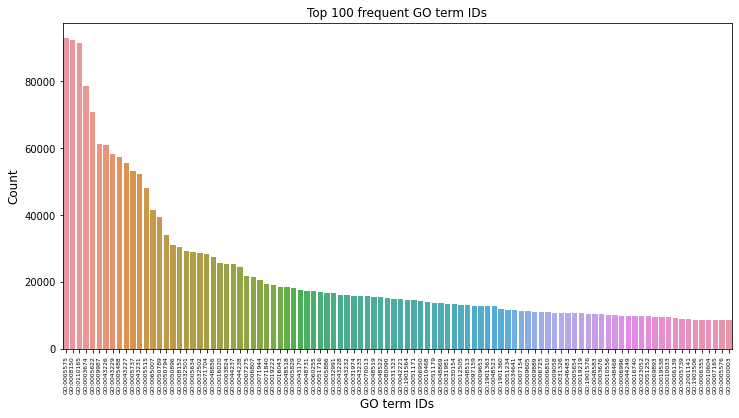

In [9]:
# Select first 1500 values for plotting
plot_df = train_terms['term'].value_counts().iloc[:100]

figure, axis = plt.subplots(1, 1, figsize=(12, 6))

bp = sns.barplot(ax=axis, x=np.array(plot_df.index), y=plot_df.values)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 6)
axis.set_title('Top 100 frequent GO term IDs')
bp.set_xlabel("GO term IDs", fontsize = 12)
bp.set_ylabel("Count", fontsize = 12)
plt.show()

We will now save the first 1500 most frequent GO term Ids into a list.

In [10]:
num_of_labels = 1500

labels = train_terms['term'].value_counts().index[:num_of_labels].tolist()

In [11]:
train_terms_updated = train_terms.loc[train_terms['term'].isin(labels)]

Let us plot the aspect values in the new **train_terms_updated** dataframe using a pie chart.

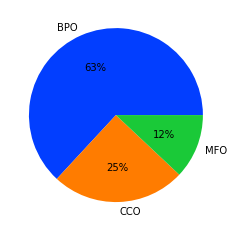

In [12]:
pie_df = train_terms_updated['aspect'].value_counts()
palette_color = sns.color_palette('bright')
plt.pie(pie_df.values, labels=np.array(pie_df.index), colors=palette_color, autopct='%.0f%%')
plt.show()

As you can see, majority of the `GO term Id`s have BPO(Biological Process Ontology) as their aspect.

Since this is a multi label classification problem, in the labels array we will denote the presence or absence of each Go Term Id for a protein id using a 1 or 0.
First, we will create a numpy array `train_labels` of required size for the labels. To update the `train_labels` array with the appropriate values, we will loop through the label list.

In [14]:
bar = progressbar.ProgressBar(maxval=num_of_labels, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

# Create an empty dataframe of required size for storing the labels,
# i.e, train_size x num_of_labels (142246 x 1500)
train_size = train_protein_ids.shape[0] # len(X)
train_labels = np.zeros((train_size ,num_of_labels))

series_train_protein_ids = pd.Series(train_protein_ids)
bar.start()
for i in range(num_of_labels):
    n_train_terms = train_terms_updated[train_terms_updated['term'] ==  labels[i]]

    label_related_proteins = n_train_terms['EntryID'].unique()

    train_labels[:,i] =  series_train_protein_ids.isin(label_related_proteins).astype(float)

    bar.update(i+1)

bar.finish()

labels_df = pd.DataFrame(data = train_labels, columns = labels)
print(labels_df.shape)

(142246, 1500)


The final labels dataframe `label_df` is composed of 1500 columns and 142246 entries. We can see all 1500 dimensions(results will be truncated since the number of columns is big) of our dataset by printing out the first 5 entries using the following code:

In [15]:
labels_df.head()

,GO:0005575,GO:0008150,GO:0110165,GO:0003674,GO:0005622,GO:0009987,GO:0043226,GO:0043229,GO:0005488,GO:0043227,...,GO:0034250,GO:0140053,GO:0031345,GO:0098802,GO:0045861,GO:0051783,GO:0031674,GO:0001818,GO:0006874,GO:0016887
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Training

Next, we will use Tensorflow to train a Deep Neural Network with the protein embeddings.

In [16]:
INPUT_SHAPE = [train_df.shape[1]]
BATCH_SIZE = 5120

model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=INPUT_SHAPE),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=num_of_labels,activation='sigmoid')
])


# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy', tf.keras.metrics.AUC()],
)

history = model.fit(
    train_df, labels_df,
    batch_size=BATCH_SIZE,
    epochs=5
)

2023-09-17 01:40:57.541844: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/openmpi-4.1.2-4a/lib:/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/python-3.9.9-jh/lib:/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/tcl-8.6.11-d4/lib:/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/sqlite-3.37.1-6s/lib:/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-10.3.0/zlib-1.2.11-2y/lib:/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-9.3.0/gcc-10.3.0-ya/lib64:/opt/sw/spack/apps/linux-rhel8-x86_64_v2/gcc-9.3.0/gcc-10.3.0-ya/lib
2023-09-17 01:40:57.541872: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-17 01:40:57.541896: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this

Epoch 1/5
28/28 [==============================] - 6s 193ms/step - loss: 0.1936 - binary_accuracy: 0.9425 - auc: 0.6881
Epoch 2/5
28/28 [==============================] - 5s 193ms/step - loss: 0.0780 - binary_accuracy: 0.9801 - auc: 0.8327
Epoch 3/5
28/28 [==============================] - 5s 195ms/step - loss: 0.0736 - binary_accuracy: 0.9803 - auc: 0.8612
Epoch 4/5
28/28 [==============================] - 5s 193ms/step - loss: 0.0699 - binary_accuracy: 0.9805 - auc: 0.8847
Epoch 5/5
28/28 [==============================] - 5s 193ms/step - loss: 0.0671 - binary_accuracy: 0.9807 - auc: 0.9011


# Summary

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 1500)              769500    
                                                                 
Total params: 1,823,708
Trainable params: 1,821,660
Non-trainable params: 2,048
__________________________________________

# Plot the model's loss and accuracy for each epoch

<AxesSubplot:title={'center':'Accuracy'}>

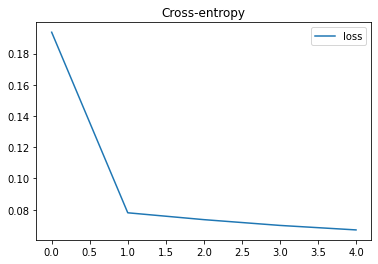

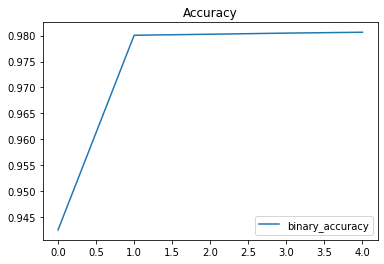

In [18]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy']].plot(title="Accuracy")

# Output on test dataset

For final output we will use the protein embeddings of the test data.

In [19]:
test_embeddings = np.load('t5_embeds/test_embeds.npy')

column_num = test_embeddings.shape[1]
test_df = pd.DataFrame(test_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(test_df.shape)

(141865, 1024)


In [20]:
test_df.head()

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.054705,0.063420,-0.015320,-0.016506,0.042195,0.021592,-0.118535,-0.063298,-0.046146,-0.102311,...,-0.019581,-0.043712,-0.072322,0.002404,0.018459,-0.047278,0.012195,-0.043319,0.036009,0.063093
1,0.090373,0.089842,-0.023887,-0.011446,0.051465,0.020982,-0.110989,-0.066646,-0.041259,-0.087551,...,-0.024399,-0.041957,-0.066329,0.006856,0.028449,-0.053758,0.009699,-0.053350,0.019644,0.079630
2,0.043588,0.039572,-0.014332,-0.011769,0.045109,0.015847,-0.103339,-0.047735,-0.022730,-0.091452,...,-0.029648,-0.037944,-0.046043,0.003603,0.018028,-0.030746,0.003671,-0.044464,0.030974,0.040322
3,0.055668,0.049560,-0.019646,-0.006977,0.039897,0.021177,-0.108079,-0.047191,-0.031517,-0.100057,...,-0.023210,-0.041704,-0.048440,0.006088,0.020110,-0.046751,-0.006635,-0.041455,0.016683,0.057030
4,0.022637,0.014306,-0.002696,-0.034456,0.034854,0.020822,-0.114046,-0.050019,-0.026491,-0.097928,...,-0.019185,-0.032108,-0.051394,0.008448,0.015208,-0.037987,0.030977,-0.042407,0.041232,0.047161


We will now use the model to make predictions on the test embeddings.

In [21]:
predictions =  model.predict(test_df)

From the predictions we will create the final output data frame.

**Note**: This will take atleast **15 to 20** minutes to finish.

In [22]:
df_final = pd.DataFrame(columns = ['Protein Id', 'GO Term Id','Prediction'])
test_protein_ids = np.load('t5_embeds/test_ids.npy')
l = []
for k in list(test_protein_ids):
    l += [ k] * predictions.shape[1]

df_final['Protein Id'] = l
df_final['GO Term Id'] = labels * predictions.shape[0]
df_final['Prediction'] = predictions.ravel()
df_final.to_csv("final_output.tsv",header=False, index=False, sep="\t")

In [23]:
df_final

,Protein Id,GO Term Id,Prediction
0,Q9CQV8,GO:0005575,0.530618
1,Q9CQV8,GO:0008150,0.524857
2,Q9CQV8,GO:0110165,0.528991
3,Q9CQV8,GO:0003674,0.528299
4,Q9CQV8,GO:0005622,0.517286
...,...,...,...
212797495,A0A3G2FQK2,GO:0051783,0.282292
212797496,A0A3G2FQK2,GO:0031674,0.301330
212797497,A0A3G2FQK2,GO:0001818,0.338075
212797498,A0A3G2FQK2,GO:0006874,0.311140


Reference: https://www.kaggle.com/code/alexandervc/baseline-multilabel-to-multitarget-binary